In [32]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Masking
from keras.optimizers import RMSprop, Adam
from keras import backend as k
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


"""
    Discrete log-likelihood for Weibull hazard function on censored survival data
    y_true is a (samples, 2) tensor containing time-to-event (y), and an event indicator (u)
    ab_pred is a (samples, 2) tensor containing predicted Weibull alpha (a) and beta (b) parameters
    For math, see https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
"""
def weibull_loglik_discrete(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)

    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)


"""
    Custom Keras activation function, outputs alpha neuron using exponentiation and beta using softplus
"""
def activate(ab):
    print("ab:")
    print(ab)
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)


"""
    Load and parse series data files into:
       - an (series, observed history, 1) x tensor, where observed history is 100 days, zero-padded
         for days that don't have a full 100 days of observed history (e.g., first observed day for a series)
       - an (series, 2) tensor containing time-to-event and 1 (all callibrations done)
"""
def load_file(name):
    with open(name, 'r') as file:
        return np.loadtxt(file, delimiter=',')

    
np.set_printoptions(suppress=True, threshold=10000)
print("START")
data_x = load_file('D:/Praca Magisterska/nowe/stddevs/train_x.csv')
data_y = load_file('D:/Praca Magisterska/nowe/stddevs/train_y.csv')

data_u = np.zeros((data_y.shape[0], 1), dtype=np.float32)
data_u += 1
data_y = np.append(np.reshape(data_y, (data_y.shape[0], 1)), data_u, axis=1)

number_of_series = 4

# Configurable observation look-back period for each series
max_time = 100

# y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
out_y = np.empty((0, 2), dtype=np.float32)
# print(out_y.shape)

# A full history of sensor readings to date for each x
out_x = np.empty((0, max_time, 2), dtype=np.float32)

print(data_x.shape)

print(data_x)
#data_x[:, 2:4] = normalize(data_x[:, 2:4].reshape(-1, 2))[:, 0:2]
#print(data_x)

for i in range(data_x.shape[0]):
    this_x = np.zeros((1, max_time, 2))
    for b in range(max_time):
        if i-max_time+b+1 < 0:
            this_x[0, b, 0] = 0
            this_x[0, b, 1] = 0
        elif data_x[i-max_time+b+1, 0] < data_x[i, 0]:
            this_x[0, b, 0] = 0
            this_x[0, b, 1] = 0
        else:
            this_x[0, b, 0] = data_x[i-max_time+b+1, 2]
            this_x[0, b, 1] = data_x[i-max_time+b+1, 3]

    out_x = np.concatenate((out_x, this_x))

print(out_x.shape)
print(out_x[95])

X_train, X_test, y_train, y_test = train_test_split(out_x, data_y, test_size=0.3)


# Start building our model
model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
model.add(Masking(mask_value=0., input_shape=(max_time, 2)))

# LSTM is just a common type of RNN. You could also try anything else (e.g., GRU).
model.add(LSTM(20, input_shape=(None, 2)))

# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
model.add(Dense(2))

# Apply the custom activation function mentioned above
model.add(Activation(activate))

# Use the discrete log-likelihood for Weibull survival data as our loss function
model.compile(loss=weibull_loglik_discrete, optimizer=Adam(lr=0.0003))
print(model.summary())
# Fit!
model.fit(X_train, y_train, epochs=200, batch_size=50, verbose=2, validation_data=(X_test, y_test))


START
(936, 4)
[[  1.           1.           0.493634     0.        ]
 [  1.           2.           0.45078905   0.82300926]
 [  1.           3.           0.45399558   0.04178241]
 [  1.           4.           0.45355014   0.04340278]
 [  1.           5.           0.45455138   0.04179398]
 [  1.           6.           0.45556192   0.04178241]
 [  1.           7.           0.45368421   0.04179398]
 [  1.           8.           0.45938308   0.04178241]
 [  1.           9.           0.46547303   0.05219907]
 [  1.          10.           0.46597679   0.04179398]
 [  1.          11.           0.46648198   0.04178241]
 [  1.          12.           0.46370938   0.04179398]
 [  1.          13.           0.47119555   0.0412963 ]
 [  1.          14.           0.46914579   0.18488426]
 [  1.          15.           0.50698033   0.39355324]
 [  1.          16.           0.50515552   0.04179398]
 [  1.          17.           0.45627248   0.04347222]
 [  1.          18.           0.45263609   0.05734

(936, 100, 2)
[[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.493634   0.        ]
 [0.45078905 0.82300926]
 [0.45399558 0.04178241]
 [0.45355014 0.04340278]
 [0.45455138 0.04179398]
 [0.45556192 0.04178241]
 [0.45368421 0.04179398]
 [0.45938308 0.04178241]
 [0.46547303 0.05219907]
 [0.46597679 0.04179398]
 [0.46648198 0.04178241]
 [0.46370938 0.04179398]
 [0.47119555 0.0412963 ]
 [0.46914579 0.18488426]
 [0.50698033 0.39355324]
 [0.50515552 0.04179398]
 [0.45627248 0.04347222]
 [0.45263609 0.05734954]
 [0.45121731 0.03655093]
 [0.45812338 0.02289352]
 [0.45362478 0.02638889]
 [0.46405954 0.06047454]
 [0.46220731 0.04178241]
 [0.45365227 0.04179398]
 [0.45935103 0.04525463]
 [0.46341602 0.03211806]
 [0.47823263 0.36734954]
 [0.4829547  0.02116898]
 [0.48217578 0.04179398]
 [0.47794229 0.02890046]
 [0.48226501 0.04171296]
 [0.63840923 0.30454861]
 [0.53344972 0.04178241]
 [0.53245574 0.05684028]
 [0.53711959 0.04178241]
 [0.5278252

Epoch 90/200
 - 2s - loss: 3.4741 - val_loss: 3.5100
Epoch 91/200
 - 2s - loss: 3.4722 - val_loss: 3.5054
Epoch 92/200
 - 2s - loss: 3.4617 - val_loss: 3.5134
Epoch 93/200
 - 2s - loss: 3.4650 - val_loss: 3.4958
Epoch 94/200
 - 2s - loss: 3.4751 - val_loss: 3.5436
Epoch 95/200
 - 2s - loss: 3.4810 - val_loss: 3.4935
Epoch 96/200
 - 2s - loss: 3.4332 - val_loss: 3.4819
Epoch 97/200
 - 2s - loss: 3.4311 - val_loss: 3.4753
Epoch 98/200
 - 2s - loss: 3.4484 - val_loss: 3.5059
Epoch 99/200
 - 2s - loss: 3.4296 - val_loss: 3.4877
Epoch 100/200
 - 2s - loss: 3.4227 - val_loss: 3.4691
Epoch 101/200
 - 2s - loss: 3.4143 - val_loss: 3.4826
Epoch 102/200
 - 2s - loss: 3.4268 - val_loss: 3.5249
Epoch 103/200
 - 2s - loss: 3.4429 - val_loss: 3.4417
Epoch 104/200
 - 2s - loss: 3.4200 - val_loss: 3.4397
Epoch 105/200
 - 2s - loss: 3.3938 - val_loss: 3.4389
Epoch 106/200
 - 2s - loss: 3.4155 - val_loss: 3.4341
Epoch 107/200
 - 2s - loss: 3.4595 - val_loss: 3.5199
Epoch 108/200
 - 2s - loss: 3.4168 - v

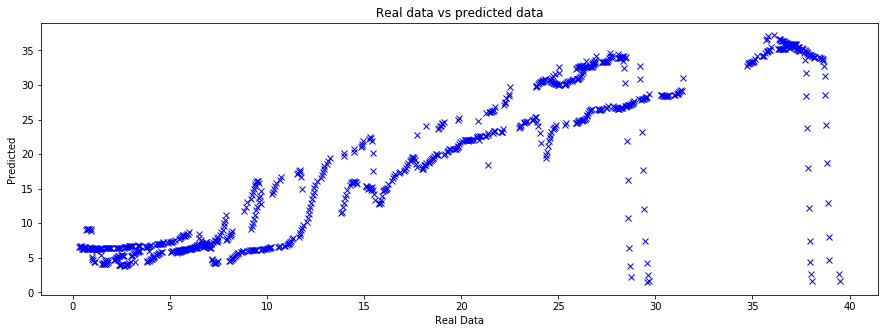

In [33]:
# Make some predictions and put them alongside the real TTE and event indicator values
test_predict = model.predict(out_x)
test_predict = np.resize(test_predict, (data_y.shape[0], 2))
test_result = np.concatenate((data_y, test_predict))


fig, ax = plt.subplots()
ax.set_title('Real data vs predicted data')
ax.plot(data_y[:, 0], test_predict[:, 0], 'bx')
plt.rcParams['figure.figsize'] = [5, 5]
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.show()

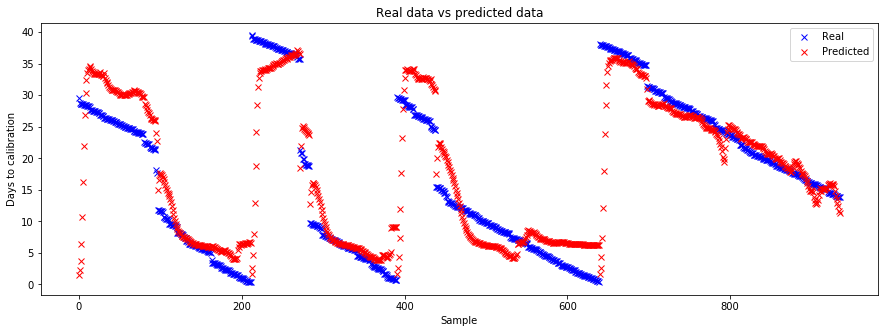

In [35]:
fig, ax = plt.subplots()
ax.set_title('Real data vs predicted data')
ax.plot(data_y[:, 0], 'bx', label='Real')
ax.plot(test_predict[:, 0], 'rx', label='Predicted')

plt.rcParams['figure.figsize'] = [15, 5]
plt.xlabel("Sample")
plt.ylabel("Days to calibration")
ax.legend()
plt.show()

In [15]:
import math
qqq = 1e-35
print(math.exp(1))

2.718281828459045
